In [108]:
import sys
sys.path.append('../code/functions/')
import tiffIO as io

import math
import cv2
import time
import pickle

import numpy as np
import synapseLib as sl
import matplotlib.pyplot as plt

from skimage.exposure import equalize_adapthist
from scipy.ndimage.filters import convolve
from skimage.filters import sobel
from skimage.morphology import dilation
from scipy.spatial import KDTree
from random import randint

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

In [2]:
data = np.array(io.loadTiff('../data/rr46b_s0_ch1.tif'))

In [3]:
axons, _ = sl.extractAxons(np.stack([equalize_adapthist(elem) for elem in data]), percentile=50)

/usr/local/lib/python2.7/dist-packages/skimage/util/dtype.py:110: UserWarning:

Possible precision loss when converting from float64 to uint16



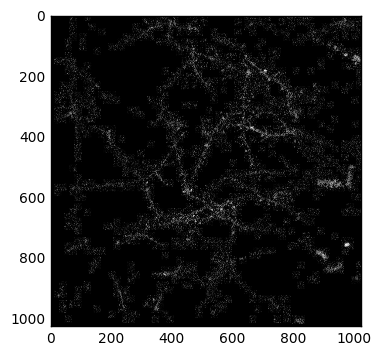

In [18]:
plt.imshow(axons[15], cmap='gray')
plt.show()

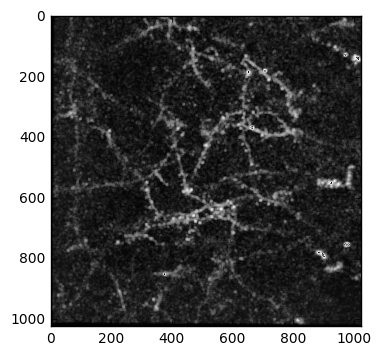

In [76]:
img = data[15]
for kernelSize in [8]:
        img = convolve(img, np.ones((kernelSize, kernelSize)))
    
img = equalize_adapthist(img)
plt.imshow(img, cmap='gray')
plt.show()

In [61]:
axons2, _ = sl.extractAxons([img], percentile=50)

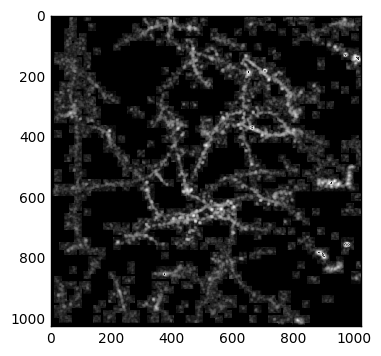

In [63]:
plt.imshow(axons2[0], cmap='gray')
plt.show()

In [4]:
def evolveAxons(data, epochs=2, n=2, neighborhood=16, dilations=5, percentile=50):
    species = data
    kernel = np.ones((8, 8))
    for i in range(epochs):
        print i
        genus, _ = sl.extractAxons(np.stack([equalize_adapthist(elem) for elem in species]),
                                     percentile=percentile,
                                     neighborhood=neighborhood,
                                     n = n,
                                     dilations=dilations)
        
        species = np.stack([convolve(elem, kernel) for elem in genus]).astype(np.int64)
        
    return species

In [5]:
axons = evolveAxons(data[10:20], epochs=10, dilations=10)

0


/usr/local/lib/python2.7/dist-packages/skimage/util/dtype.py:110: UserWarning:

Possible precision loss when converting from float64 to uint16



1


/usr/local/lib/python2.7/dist-packages/skimage/util/dtype.py:106: UserWarning:

Possible sign loss when converting negative image of type int64 to positive image of type uint16.

/usr/local/lib/python2.7/dist-packages/skimage/util/dtype.py:136: UserWarning:

Downcasting int64 to uint16 without scaling because max value 41 fits in uint16

/usr/local/lib/python2.7/dist-packages/skimage/util/dtype.py:136: UserWarning:

Downcasting int64 to uint16 without scaling because max value 49 fits in uint16

/usr/local/lib/python2.7/dist-packages/skimage/util/dtype.py:136: UserWarning:

Downcasting int64 to uint16 without scaling because max value 50 fits in uint16

/usr/local/lib/python2.7/dist-packages/skimage/util/dtype.py:136: UserWarning:

Downcasting int64 to uint16 without scaling because max value 55 fits in uint16

/usr/local/lib/python2.7/dist-packages/skimage/util/dtype.py:136: UserWarning:

Downcasting int64 to uint16 without scaling because max value 48 fits in uint16

/usr/local/lib/p

2


/usr/local/lib/python2.7/dist-packages/skimage/util/dtype.py:136: UserWarning:

Downcasting int64 to uint16 without scaling because max value 61 fits in uint16

/usr/local/lib/python2.7/dist-packages/skimage/util/dtype.py:136: UserWarning:

Downcasting int64 to uint16 without scaling because max value 58 fits in uint16

/usr/local/lib/python2.7/dist-packages/skimage/util/dtype.py:136: UserWarning:

Downcasting int64 to uint16 without scaling because max value 59 fits in uint16



3


/usr/local/lib/python2.7/dist-packages/skimage/util/dtype.py:136: UserWarning:

Downcasting int64 to uint16 without scaling because max value 62 fits in uint16

/usr/local/lib/python2.7/dist-packages/skimage/util/dtype.py:136: UserWarning:

Downcasting int64 to uint16 without scaling because max value 60 fits in uint16



4


/usr/local/lib/python2.7/dist-packages/skimage/util/dtype.py:136: UserWarning:

Downcasting int64 to uint16 without scaling because max value 63 fits in uint16



5
6
7
8
9


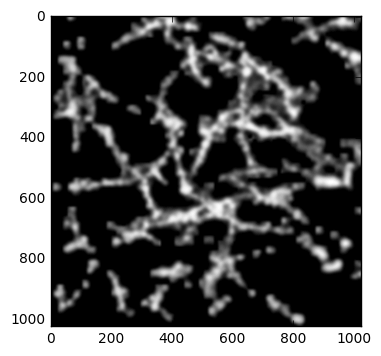

In [138]:
plt.imshow(axons[5], cmap='gray')
plt.show()

In [141]:
kernelX = [[1,0,-1],
           [2, 0, -2],
           [1, 0, -1]]

kernelY = [[1, 2, 1],
           [0, 0, 0],
           [-1, -2, -1]]

In [143]:
xGrad = convolve(axons[5], kernelX)
yGrad = convolve(axons[5], kernelY)
grad = np.sqrt(np.add(np.power(xGrad, 2), np.power(yGrad, 2)))

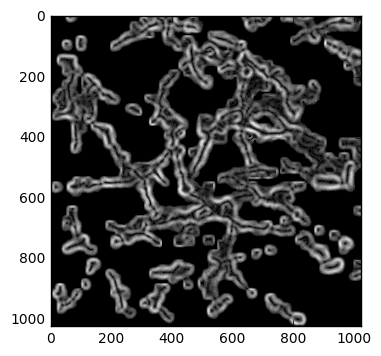

In [144]:
plt.imshow(grad, cmap='gray')
plt.show()

In [161]:
kernel = np.ones((16, 16))

kernel[1:15, 1:15] = 0
'''
kernel[7, 7] = -6
kernel[7, 8] = -6
kernel [8, 7] = -6
kernel[8, 8] = -6
'''

'\nkernel[7, 7] = -6\nkernel[7, 8] = -6\nkernel [8, 7] = -6\nkernel[8, 8] = -6\n'

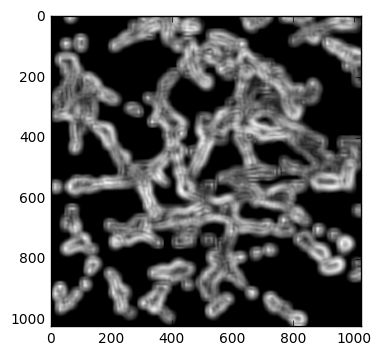

In [162]:
nodes = convolve(grad, kernel)
plt.imshow(nodes, cmap='gray')
plt.show()

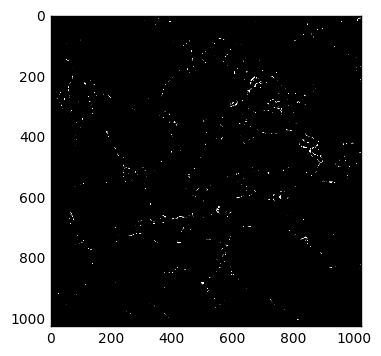

In [166]:
test = np.logical_and(np.logical_xor(nodes, grad), axons[5])
plt.imshow(test, cmap='gray')
plt.show()

In [8]:
def generateNodeImg(axonImg, step=64):
    
    kernelX = [[1,0,-1],
           [2, 0, -2],
           [1, 0, -1]]

    kernelY = [[1, 2, 1],
           [0, 0, 0],
           [-1, -2, -1]]
    
    xGrad = convolve(axons[5], kernelX)
    yGrad = convolve(axons[5], kernelY)
    grad = np.sqrt(np.add(np.power(xGrad, 2), np.power(yGrad, 2)))
    
    symmetryKernel = np.ones((16, 16))
    symmetryKernel[1:15, 1:15] = 0
    symmetryKernel[7:9, 7:9] = -1
    
    potentialNodes = convolve(grad, symmetryKernel)
    
    nodes = np.multiply(np.logical_and(np.logical_xor(potentialNodes, grad), axonImg), axonImg) 
    
    nonMaxSuppression = np.zeros_like(nodes)
    
    for y in range(0, 1024, step):
        for x in range(0, 1024, step):
            sub = nodes[y:y+step, x:x+step]
            
            aMax = np.argmax(sub)
            yMax = aMax/step
            xMax = aMax%step
            
            nonMaxSuppression[y+yMax, x+xMax] = sub[yMax, xMax]
            
    return nonMaxSuppression
    

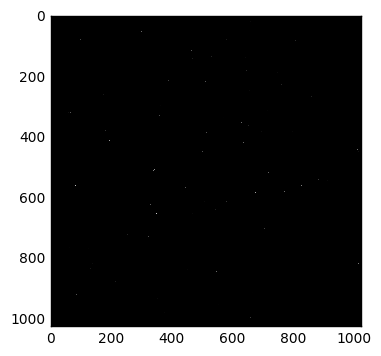

In [94]:
nodeImg = generateNodeImg(axons[5], 64)
plt.imshow(nodeImg, cmap='gray')
plt.show()

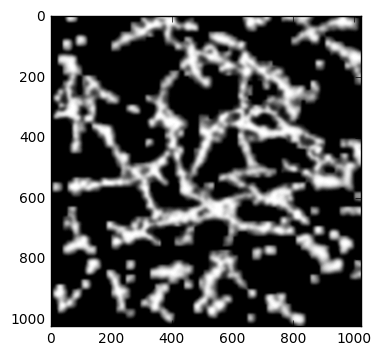

In [95]:
plt.imshow(axons[5], cmap='gray')
plt.show()

In [96]:
print np.count_nonzero(nodeImg)
print len(zip(*(np.nonzero(nodeImg))))

176
176


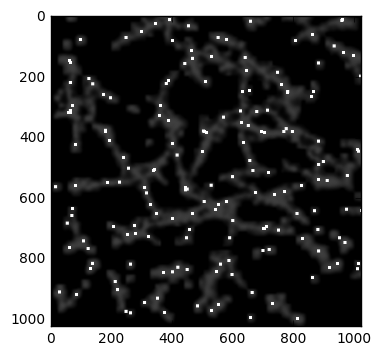

In [97]:
axCp = axons[5].copy()
for node in zip(*(np.nonzero(nodeImg))):
    axCp[node[0]-5:node[0]+5, node[1]-5:node[1]+5] = 255

plt.imshow(axCp, cmap='gray')
plt.show()

In [104]:
def generateGraph(nodeImg, axons, thickness=10, meanThresh = 50, devThresh = 10):
    axCp = axons.copy()
    
    aves = []
    devs = []
    potEdges = []
    edges = []
    
    nodes = zip(*(np.nonzero(nodeImg)))
    for i in range(len(nodes)):
        print i/float(len(nodes))
        for j in range(i+1, len(nodes)):
           
            y0, x0 = nodes[i]
            y1, x1 = nodes[j]
            
            length = int(np.hypot(x1-x0, y1-y0))
            x, y = np.linspace(x0, x1, length).astype(int), np.linspace(y0, y1, length).astype(int)                
            potEdges.append([y, x])    
            
            potEdgeStats = []
            for k in range(length):
                sub = axons[max(y[k]-thickness,0):min(y[k]+thickness, 1024), max(x[k]-thickness, 0):min(x[k]+thickness, 1024)]
                potEdgeStats.append(np.mean(sub))           
    
            aves.append(np.mean(potEdgeStats))
            devs.append(np.std(potEdgeStats))
    
    meanCut = np.percentile(aves, meanThresh)
    devCut = np.percentile(devs, devThresh)
    
    for i in range(len(potEdges)):
        if aves[i] > meanCut and devs[i] < devCut:
            edges.append(potEdges[i])
    
    for edge in edges:
        y = edge[0]
        x = edge[1]
        for k in range(len(y)):
            axCp[max(y[k]-3,0):min(y[k]+3, 1024), max(x[k]-3, 0):min(x[k]+3, 1024)] = 255
    
    return nodes, edges, axCp
        

In [105]:
nodes, edges, vis = generateGraph(nodeImg, axons[5])

0.0
0.00568181818182
0.0113636363636
0.0170454545455
0.0227272727273
0.0284090909091
0.0340909090909
0.0397727272727
0.0454545454545
0.0511363636364
0.0568181818182
0.0625
0.0681818181818
0.0738636363636
0.0795454545455
0.0852272727273
0.0909090909091
0.0965909090909
0.102272727273
0.107954545455
0.113636363636
0.119318181818
0.125
0.130681818182
0.136363636364
0.142045454545
0.147727272727
0.153409090909
0.159090909091
0.164772727273
0.170454545455
0.176136363636
0.181818181818
0.1875
0.193181818182
0.198863636364
0.204545454545
0.210227272727
0.215909090909
0.221590909091
0.227272727273
0.232954545455
0.238636363636
0.244318181818
0.25
0.255681818182
0.261363636364
0.267045454545
0.272727272727
0.278409090909
0.284090909091
0.289772727273
0.295454545455
0.301136363636
0.306818181818
0.3125
0.318181818182
0.323863636364
0.329545454545
0.335227272727
0.340909090909
0.346590909091
0.352272727273
0.357954545455
0.363636363636
0.369318181818
0.375
0.380681818182
0.386363636364
0.392045454

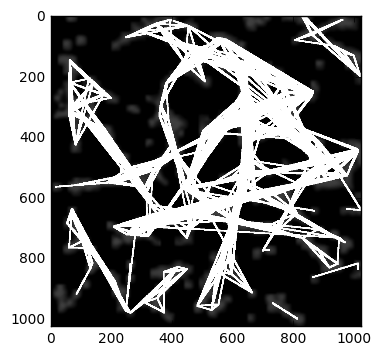

In [106]:
plt.imshow(vis, cmap='gray')
plt.show()

In [157]:
def estimateGraph(nodeImg, axons, thickness=10, neighbors=6, baselineSize=10):
    axCp = axons.copy()
    
    baseline = []
    for i in range(baselineSize):
        y0, x0 = randint(0, axons.shape[0]), randint(0, axons.shape[1])
        y1, x1 = randint(0, axons.shape[0]), randint(0, axons.shape[1])
    
        length = int(np.hypot(x1-x0, y1-y0))
        x, y = np.linspace(x0, x1, length).astype(int), np.linspace(y0, y1, length).astype(int)   
        
        edgeStats = []
        for k in range(length):
            sub = axons[max(y[k]-thickness,0):min(y[k]+thickness, 1024), max(x[k]-thickness, 0):min(x[k]+thickness, 1024)]
            edgeStats.append(np.mean(sub))
        
        baseline.append(np.mean(edgeStats))
    
    baseMu = np.mean(baseline)
    baseSig = np.std(baseline)
    
    edges = []
    
    nodes = zip(*(np.nonzero(nodeImg)))
    tree = KDTree(nodes)
    for curIdx, node in enumerate(nodes):
        print curIdx/float(len(nodes))
        partnerIdxList = tree.query(node, k=neighbors)[1]
        partners = []
        for partnerIdx in partnerIdxList:
            if partnerIdx > curIdx:
                partners.append(nodes[partnerIdx])
                
        for partner in partners:
            y0, x0 = node
            y1, x1 = partner
            
            length = int(np.hypot(x1-x0, y1-y0))
            x, y = np.linspace(x0, x1, length).astype(int), np.linspace(y0, y1, length).astype(int)                
            
            edgeStats = []
            for k in range(length):
                sub = axons[max(y[k]-thickness,0):min(y[k]+thickness, 1024), max(x[k]-thickness, 0):min(x[k]+thickness, 1024)]
                edgeStats.append(np.mean(sub))           
    
            dp = np.mean(edgeStats)
            z = (dp - baseMu)/float(baseSig)
            if z > 1.5:
                edges.append([y, x])

    for edge in edges:
        y = edge[0]
        x = edge[1]
        for k in range(len(y)):
            axCp[max(y[k]-3,0):min(y[k]+3, 1024), max(x[k]-3, 0):min(x[k]+3, 1024)] = 255
    
    return nodes, edges, axCp
        

In [158]:
nodes, edges, vis = estimateGraph(nodeImg, axons[5])

0.0
0.00568181818182
0.0113636363636
0.0170454545455
0.0227272727273
0.0284090909091
0.0340909090909
0.0397727272727
0.0454545454545
0.0511363636364
0.0568181818182
0.0625
0.0681818181818
0.0738636363636
0.0795454545455
0.0852272727273
0.0909090909091
0.0965909090909
0.102272727273
0.107954545455
0.113636363636
0.119318181818
0.125
0.130681818182
0.136363636364
0.142045454545
0.147727272727
0.153409090909
0.159090909091
0.164772727273
0.170454545455
0.176136363636
0.181818181818
0.1875
0.193181818182
0.198863636364
0.204545454545
0.210227272727
0.215909090909
0.221590909091
0.227272727273
0.232954545455
0.238636363636
0.244318181818
0.25
0.255681818182
0.261363636364
0.267045454545
0.272727272727
0.278409090909
0.284090909091
0.289772727273
0.295454545455
0.301136363636
0.306818181818
0.3125
0.318181818182
0.323863636364
0.329545454545
0.335227272727
0.340909090909
0.346590909091
0.352272727273
0.357954545455
0.363636363636
0.369318181818
0.375
0.380681818182
0.386363636364
0.392045454

In [160]:
class anatomy:
    def __init__(self, nodes, edges, vis):
        self._nodes = nodes
        self._edges = edges
        self._vis = vis

def generateAnatomyVolume(data):
    
    anatomyVolume = []
    
    axonImgs = evolveAxons(data, epochs=10, dilations=10)
    for axonImg in axonImgs:
        nodeImg = generateNodeImg(axonImg, 64)
        nodes, edges, vis = estimateGraph(nodeImg, axonImg)
        anatomyVolume.append(anatomy(nodes, edges, vis))
    
    return anatomyVolume

In [167]:
data2 = np.array(io.loadTiff('../data/rr46b_s1_ch1.tif')) 
start = time.time()
anatomyVol = generateAnatomyVolume(data2[10:15])

0
1
2
3
4
5
6
7
8
9
0.0
0.00471698113208
0.00943396226415
0.0141509433962
0.0188679245283
0.0235849056604
0.0283018867925
0.0330188679245
0.0377358490566
0.0424528301887
0.0471698113208
0.0518867924528
0.0566037735849
0.061320754717
0.0660377358491
0.0707547169811
0.0754716981132
0.0801886792453
0.0849056603774
0.0896226415094
0.0943396226415
0.0990566037736
0.103773584906
0.108490566038
0.11320754717
0.117924528302
0.122641509434
0.127358490566
0.132075471698
0.13679245283
0.141509433962
0.146226415094
0.150943396226
0.155660377358
0.160377358491
0.165094339623
0.169811320755
0.174528301887
0.179245283019
0.183962264151
0.188679245283
0.193396226415
0.198113207547
0.202830188679
0.207547169811
0.212264150943
0.216981132075
0.221698113208
0.22641509434
0.231132075472
0.235849056604
0.240566037736
0.245283018868
0.25
0.254716981132
0.259433962264
0.264150943396
0.268867924528
0.27358490566
0.278301886792
0.283018867925
0.287735849057
0.292452830189
0.297169811321
0.301886792453
0.306603

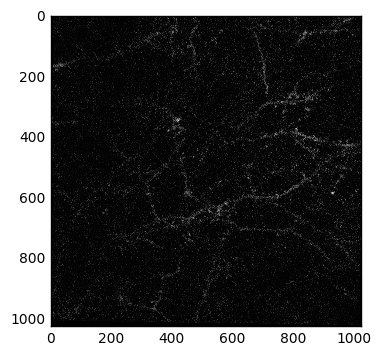

In [181]:
plt.imshow(equalize_adapthist(data2[10])*1000, cmap='gray')
plt.show()

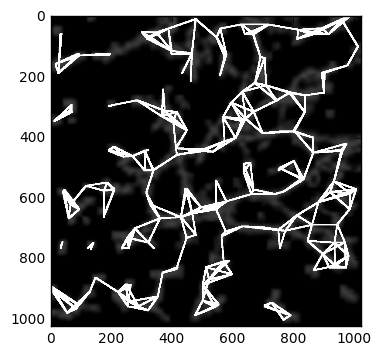

In [174]:
plt.imshow(anatomyVol[0]._vis, cmap='gray')
plt.show()

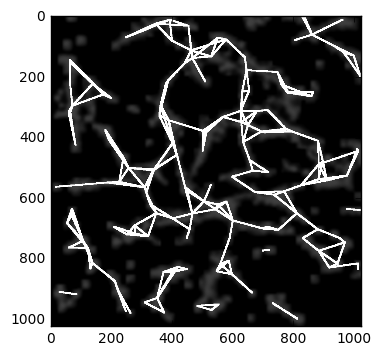

In [159]:
plt.imshow(vis, cmap='gray')
plt.show()